In [282]:
import numpy as np
import matplotlib 
import matplotlib as mpl

import lightkurve as lk

from gatspy import  periodic

from tqdm import tqdm

import glob, os

from astropy.table import Table
from astropy.io import fits
import fitsio

%pylab inline --no-import-all
matplotlib.rcParams['image.origin'] = 'lower'
matplotlib.rcParams['figure.figsize']=(10.0,10.0)    #(6.0,4.0)
matplotlib.rcParams['font.size']=16              #10 
matplotlib.rcParams['savefig.dpi']= 300             #72 
colours = mpl.rcParams['axes.prop_cycle'].by_key()['color']
mpl.rcParams["font.family"] = "Times New Roman"


Populating the interactive namespace from numpy and matplotlib


In [2]:
data = lk.search_lightcurvefile('CR Dra').download()
tpf = lk.search_targetpixelfile('CR Dra').download()

In [3]:
lc = data.PDCSAP_FLUX.remove_nans().normalize()

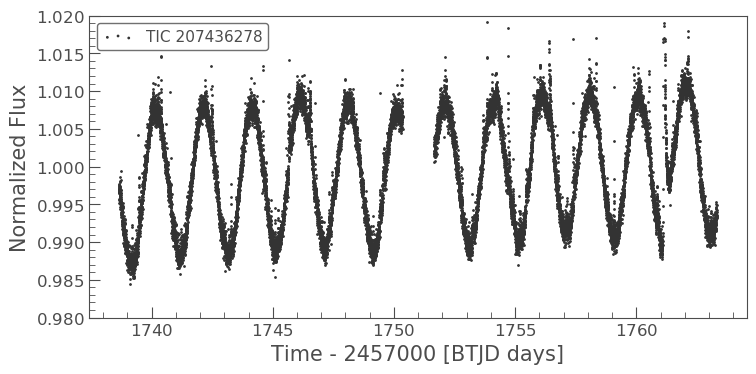

In [4]:
lc.scatter()
plt.ylim(0.98,1.02)
plt.savefig('cr_dra.png')

In [5]:
tpf.interact()

In [6]:
bg = tpf.get_bkg_lightcurve()

(1760, 1762)

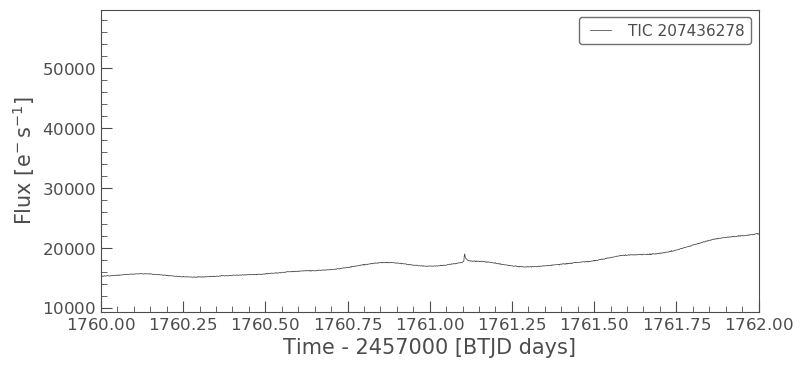

In [7]:
bg.plot()
plt.xlim(1760,1762)

In [8]:
pgram = lc.to_periodogram()

In [9]:
from astropy.timeseries import LombScargle

In [10]:
ls = LombScargle(lc.time,lc.flux,lc.flux_err)

In [11]:
periods = np.linspace(0.5,5,50000)
freqs = 1./periods[::-1]

In [12]:
%%time
power = ls.power(freqs)

CPU times: user 31.2 s, sys: 156 ms, total: 31.4 s
Wall time: 30.9 s


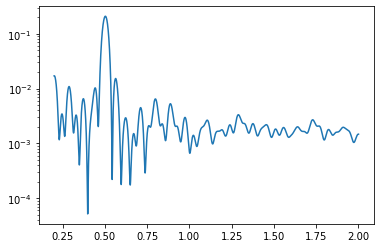

In [13]:
plt.plot(freqs,power)
plt.yscale('log')

In [14]:
1./(freqs[np.argmax(power)])

1.9881797635952723

In [15]:
model = ls.model(lc.time,freqs[np.argmax(power)])

In [16]:
fourier = LombScargle(lc.time,lc.flux,lc.flux_err,nterms=2)

In [17]:
series = fourier.model(lc.time,freqs[np.argmax(power)])

(0.98, 1.02)

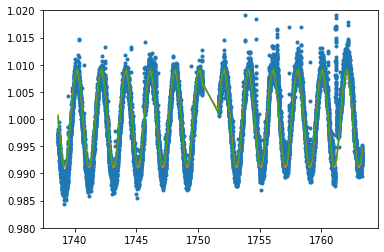

In [18]:

plt.plot(lc.time,lc.flux,'.')
plt.plot(lc.time,model)
plt.plot(lc.time,series)
plt.ylim(0.98,1.02)

(-0.01, 0.01)

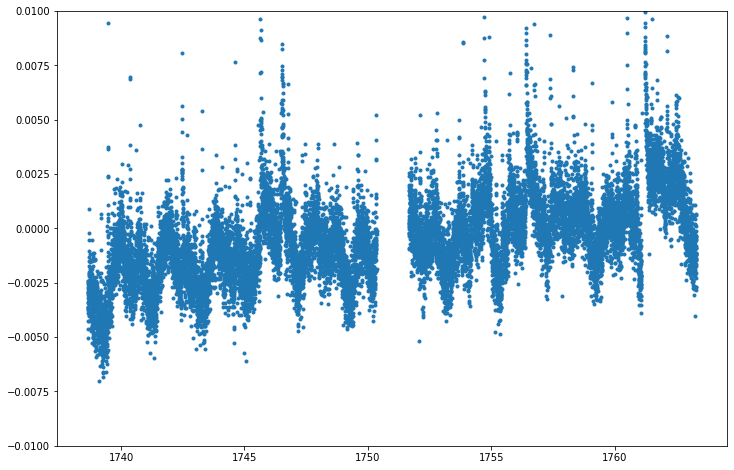

In [19]:
fig = plt.figure(figsize=(12.0,8.0))
plt.plot(lc.time,lc.flux-series,'.')
plt.ylim(-0.01,0.01)

In [20]:
flat, trend = lc.flatten(return_trend=True)

(0.98, 1.02)

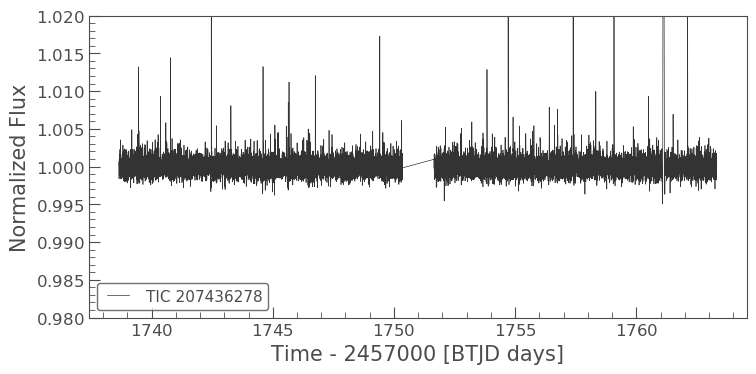

In [21]:
flat.plot()
plt.ylim(0.98,1.02)

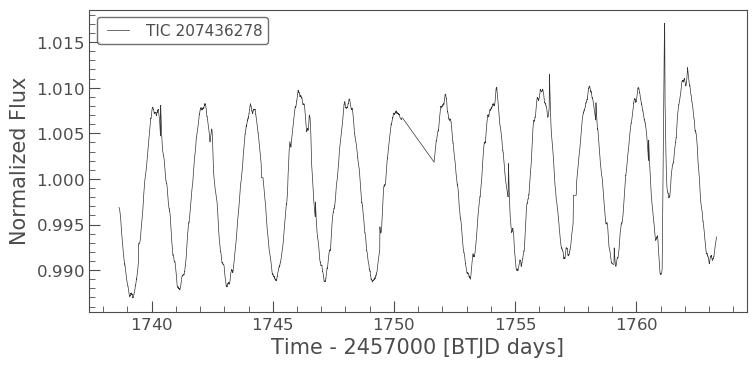

In [22]:
trend.plot()

In [23]:
lc.targetid

207436278

In [24]:
date = lk.utils.btjd_to_astropy_time(lc.time)

In [25]:
start = date.to_datetime()[0]
end = date.to_datetime()[-1]

In [26]:
print(start.date())
print(end.date())

2019-09-12
2019-10-06


In [27]:
lc2 = lc.copy()
lc2.flux = lc.flux - series + np.nanmedian(series)

(0.98, 1.02)

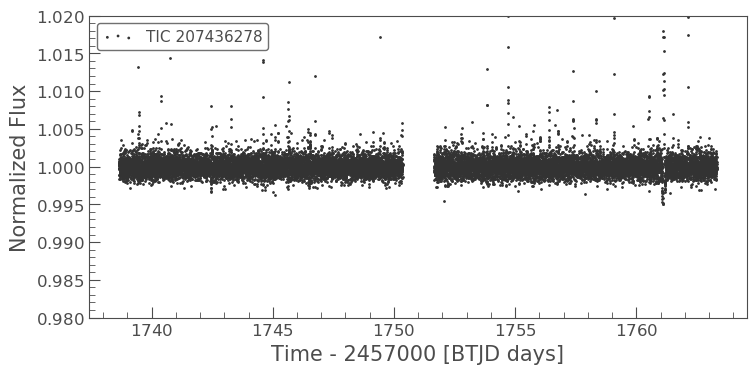

In [28]:
lc2.flatten().scatter()
plt.ylim(0.98,1.02)


In [29]:
cleaned, outliers = lc2.flatten().remove_outliers(return_mask=True)

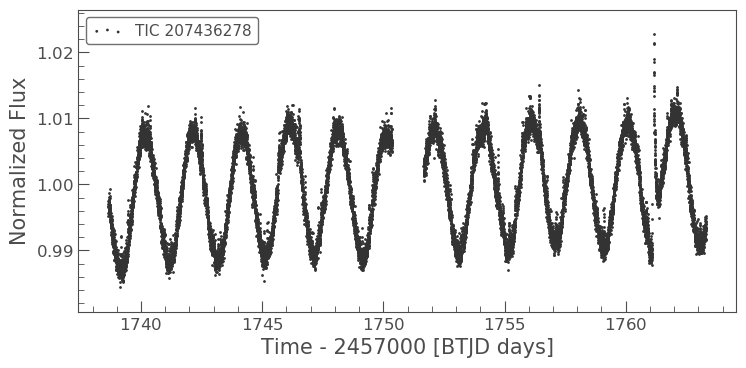

In [30]:
lc[~outliers].scatter()

In [31]:
%%time

tmodel = periodic.TrendedLombScargle(fit_period=True,Nterms=2)
tmodel.quiet = True
tmodel.optimizer.period_range = (1.9, 2.1)

lc_test = lc.copy()
outliers = [0]

for j in tqdm(range(5),desc='Outlier clipping',postfix={'Outliers':np.sum(outliers)}):
    
    tm = tmodel.fit(lc_test.time, lc_test.flux, lc_test.flux_err)
    series = tm.predict(lc_test.time)
    lc2 = lc_test.copy()
    lc2.flux = lc_test.flux - series + np.nanmedian(series)
    cleaned, outliers = lc2.remove_outliers(return_mask=True,sigma=3.0)
    
    lc_test = lc_test[~outliers]
final = tm.predict(lc.time)

Outlier clipping:   0%|          | 0/5 [00:00<?, ?it/s, Outliers=0]

Finding optimal frequency:
 - Estimated peak width = 0.255
 - Using 5 steps per peak; omega_step = 0.0509
 - User-specified period range:  1.9 to 2.1
 - Computing periods at 8 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


Outlier clipping:  20%|██        | 1/5 [00:00<00:01,  2.13it/s, Outliers=0]

Finding optimal frequency:
 - Estimated peak width = 0.255
 - Using 5 steps per peak; omega_step = 0.0509
 - User-specified period range:  1.9 to 2.1
 - Computing periods at 8 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


Outlier clipping:  40%|████      | 2/5 [00:00<00:01,  2.11it/s, Outliers=0]

Finding optimal frequency:
 - Estimated peak width = 0.255
 - Using 5 steps per peak; omega_step = 0.0509
 - User-specified period range:  1.9 to 2.1
 - Computing periods at 8 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


Outlier clipping:  60%|██████    | 3/5 [00:01<00:00,  2.10it/s, Outliers=0]

Finding optimal frequency:
 - Estimated peak width = 0.255
 - Using 5 steps per peak; omega_step = 0.0509
 - User-specified period range:  1.9 to 2.1
 - Computing periods at 8 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


Outlier clipping:  80%|████████  | 4/5 [00:01<00:00,  2.12it/s, Outliers=0]

Finding optimal frequency:
 - Estimated peak width = 0.255
 - Using 5 steps per peak; omega_step = 0.0509
 - User-specified period range:  1.9 to 2.1
 - Computing periods at 8 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


Outlier clipping: 100%|██████████| 5/5 [00:02<00:00,  2.12it/s, Outliers=0]

CPU times: user 9.33 s, sys: 76.7 ms, total: 9.41 s
Wall time: 2.38 s


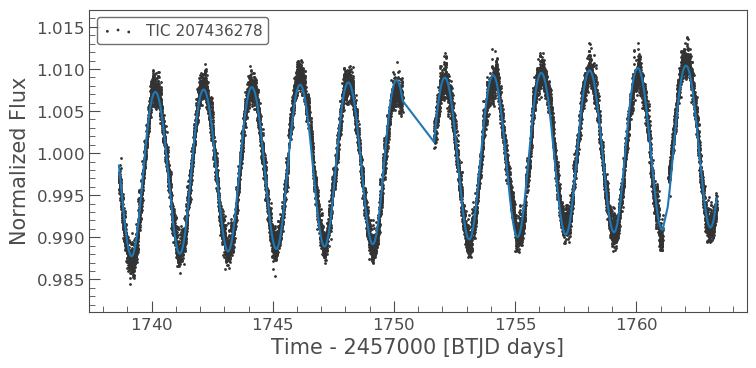

In [32]:
lc_test.scatter()
plt.plot(lc_test.time,series,color=colours[0])

<Figure size 864x432 with 0 Axes>

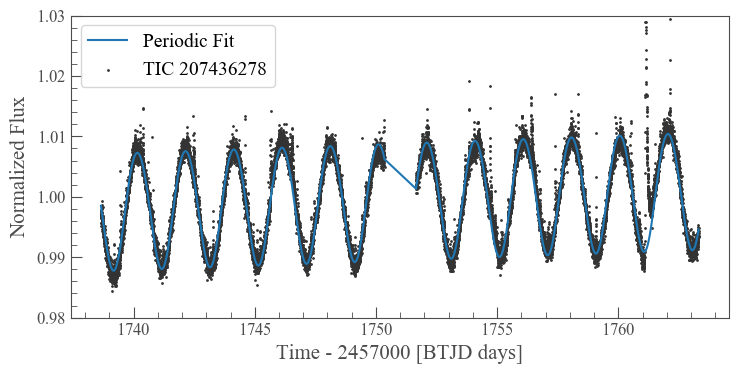

In [346]:
fig = plt.figure(figsize = (12.0,6.0))
lc.scatter()
plt.plot(lc.time,final,color=colours[0],label='Periodic Fit')
plt.legend(frameon=True,fontsize=14)
plt.ylim(0.98,1.03)
plt.savefig('cr_dra_trend.pdf',bbox_inches='tight')
plt.savefig('cr_dra_trend.png',bbox_inches='tight')

(0.98, 1.02)

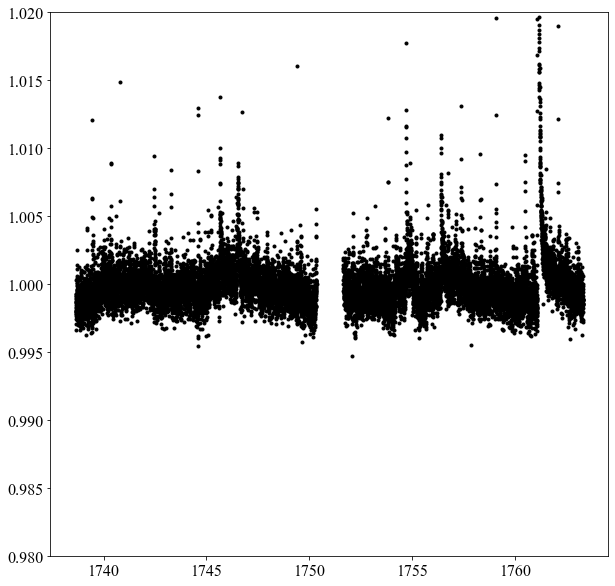

In [315]:
plt.plot(lc.time,lc.flux-final+np.nanmedian(final),'.k')
plt.ylim(0.98,1.02)

In [316]:
lk.corrector.Corrector

lightkurve.correctors.corrector.Corrector

In [317]:
cbvs = fitsio.FITS('../data/tess2019253231442-s0016-3-4-0152-s_cbv.fits')

In [318]:
cbvs


  file: ../data/tess2019253231442-s0016-3-4-0152-s_cbv.fits
  mode: READONLY
  extnum hdutype         hduname[v]
  0      IMAGE_HDU       PRIMARY[1]
  1      BINARY_TBL      CBV.single-scale.3.4[1]
  2      BINARY_TBL      CBV.spike.3.4[1]
  3      BINARY_TBL      CBV.multiscale-band-1.3.4[1]
  4      BINARY_TBL      CBV.multiscale-band-2.3.4[1]
  5      BINARY_TBL      CBV.multiscale-band-3.3.4[1]

In [319]:
dummy = []
cadenceno = cbvs[4]['CADENCENO'][:]
for j in range(8):
    dummy.append(cbvs[4]['VECTOR_%d' % (j+1)][:])
cbvs_mat = np.vstack(dummy)

In [320]:
def match_cadences(cbvcads,lccads):
    indices =np.array([1 if j in lccads else 0 for j in cbvcads])
    return np.where(indices==1)[0]


In [321]:
match = match_cadences(cadenceno,lc_test.cadenceno)

In [322]:

regressors = cbvs_mat[:,match].T
dm = lk.DesignMatrix(regressors, name='regressors')


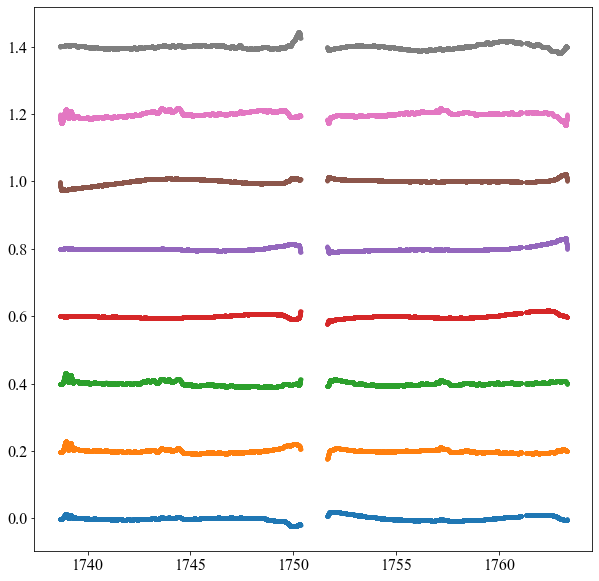

In [323]:
plt.plot(lc_test.time, dm.values + np.arange(8)*0.2, '.');


In [324]:
dm = dm.append_constant()

In [325]:
residuals = lc_test.copy()
residuals.flux = lc_test.flux - series + np.nanmedian(series)
corrector = lk.RegressionCorrector(residuals)

In [326]:
corrected_lc = corrector.correct(dm)


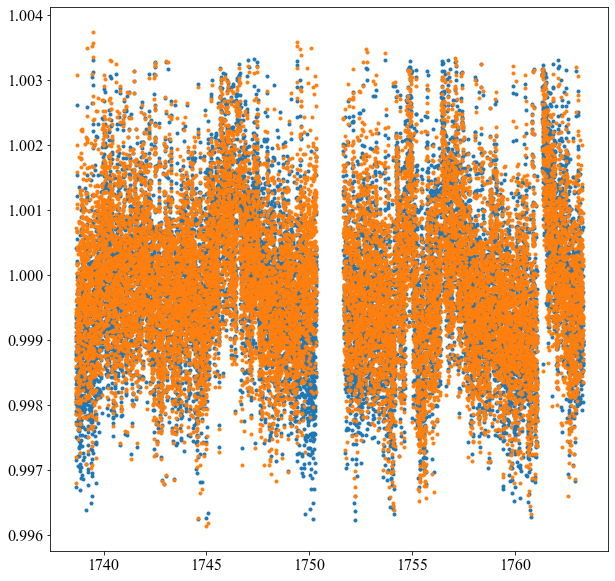

In [327]:
plt.plot(residuals.time,residuals.flux,'.')
plt.plot(corrected_lc.time,corrected_lc.flux,'.')

In [328]:
tm.best_period

1.990524996521418

### Now let's look at the radio data

In [50]:
radio = Table.read('cr_dra_priorised_I.fits')
dates = Table.read('date_obs_crdra.fits')

In [52]:
from astropy.time import Time

In [188]:
t = Time(dates['date_obs'], format='isot', scale='utc').mjd

In [189]:
flux = radio['int_flux']
error = radio['err_int_flux']

<ErrorbarContainer object of 3 artists>

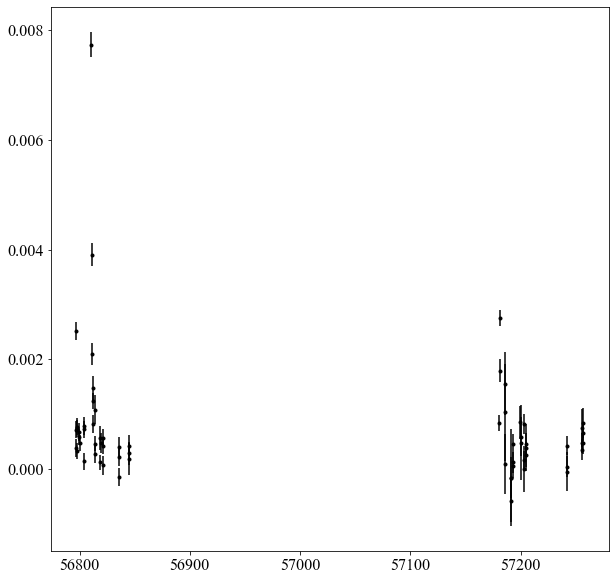

In [286]:
plt.errorbar(t,flux,yerr=error,fmt='.k')
# plt.xlim(56780,56850)

In [312]:
bad = (flux>0.0015) + (t>56810)*(t<56820)  + (error>0.00085)

<ErrorbarContainer object of 3 artists>

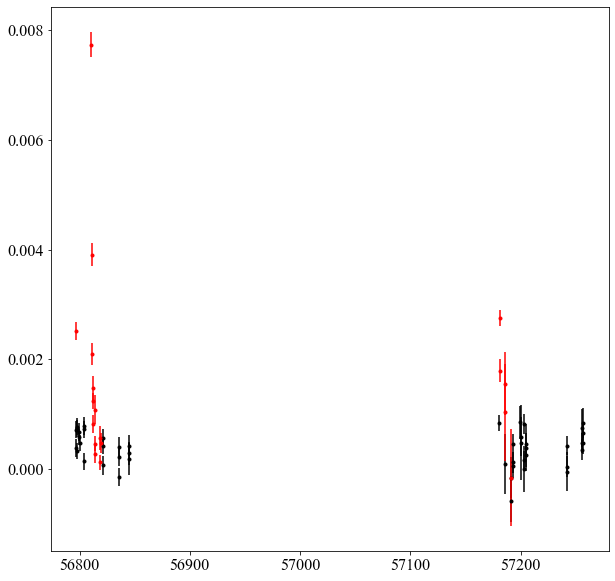

In [313]:
plt.errorbar(t[~bad],flux[~bad],yerr=error[~bad],fmt='.k')
plt.errorbar(t[bad],flux[bad],yerr=error[bad],fmt='.r')
# plt.xlim(56780,56850)
# plt.xlim(56780,56850)

In [193]:
from astropy.timeseries import TimeSeries
import astropy.units as u


In [194]:
ts = TimeSeries(time=Time(dates['date_obs'], format='isot', scale='utc')[~bad],data=radio[~bad])

In [248]:
folded = ts.fold(tm.best_period*u.day,midpoint_epoch = ts['time'][12])

In [260]:
gg = []
for j, epoch in enumerate(ts['time']):
    folded = ts.fold(tm.best_period*u.day,midpoint_epoch = epoch)
    gaps = np.diff(folded['time'])
    gg.append(np.nanstd(gaps))
gg = [g.value for g in gg]

In [263]:
folded = ts.fold(tm.best_period*u.day,midpoint_epoch = ts['time'][19])

<ErrorbarContainer object of 3 artists>

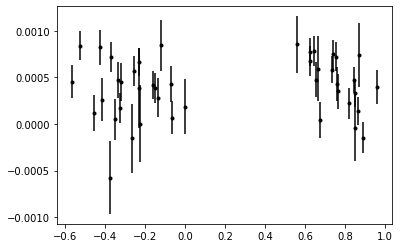

In [264]:
plt.errorbar(folded['time'].jd,folded['int_flux'],yerr=folded['err_int_flux'],fmt='.k')

In [265]:
ls_raw = LombScargle(t,flux,error)
ls_radio = LombScargle(t[~bad],flux[~bad],error[~bad])

In [266]:
%%time
periods = np.linspace(0.5,5,50000)
freqs = 1./periods[::-1]
power_radio = ls_radio.power(freqs)
power_raw = ls_raw.power(freqs)

CPU times: user 229 ms, sys: 3.44 ms, total: 232 ms
Wall time: 231 ms


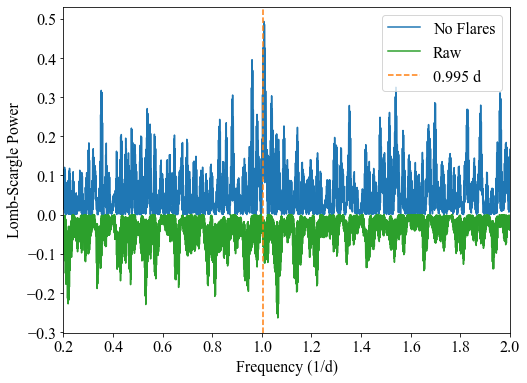

In [347]:
fig = plt.figure(figsize=(8.0,6.0))

plt.plot(freqs,power_radio,color=colours[0],label='No Flares')
plt.plot(freqs,-power_raw,color=colours[2],label='Raw')

plt.axvline(2./tm.best_period,linestyle='--',color=colours[1],label='%.3f d' % (tm.best_period/2.))
# plt.yscale('log')
plt.xlim(freqs.min(),freqs.max())
plt.xlabel(r'Frequency (1/d)')
plt.ylabel('Lomb-Scargle Power')
plt.legend()
plt.savefig('cr_dra_lomb_scargle.pdf',bbox_inches='tight')
plt.savefig('cr_dra_lomb_scargle.png',bbox_inches='tight')

In [329]:
ls_radio.false_alarm_probability(power_radio.max()) 

<Quantity 0.00091587>

In [330]:
ls_raw.false_alarm_probability(power_raw.max()) 

<Quantity 0.0746856>